Found 5218 files belonging to 2 classes.
Using 3653 files for training.
Found 5218 files belonging to 2 classes.
Using 1565 files for validation.
Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 80s 650ms/step - accuracy: 0.6081 - loss: 0.7013 - val_accuracy: 0.9284 - val_loss: 0.2654
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 644ms/step - accuracy: 0.8635 - loss: 0.3123 - val_accuracy: 0.9348 - val_loss: 0.2056
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 642ms/step - accuracy: 0.8984 - loss: 0.2454 - val_accuracy: 0.9380 - val_loss: 0.1809
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 650ms/step - accuracy: 0.9174 - loss: 0.2146 - val_accuracy: 0.9380 - val_loss: 0.1746
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 648ms/step - accuracy: 0.9146 - loss: 0.1941 - val_accuracy: 0.9508 - val_loss: 0.1474
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 646ms/step - accuracy: 0.9311 - loss: 0.1829 - val_accuracy: 0.9438 - val_loss: 0.1556
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 648ms/step - accuracy: 0

2025-07-10 21:18:07.323405: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


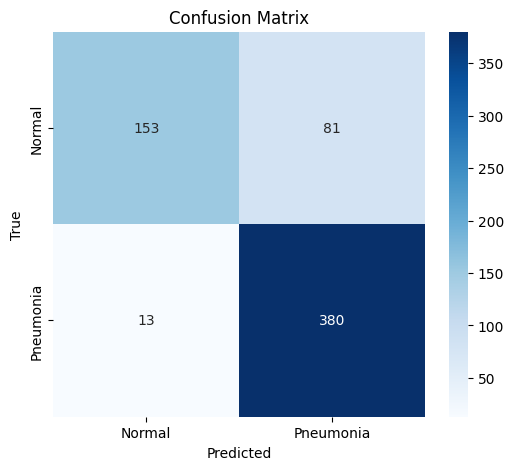

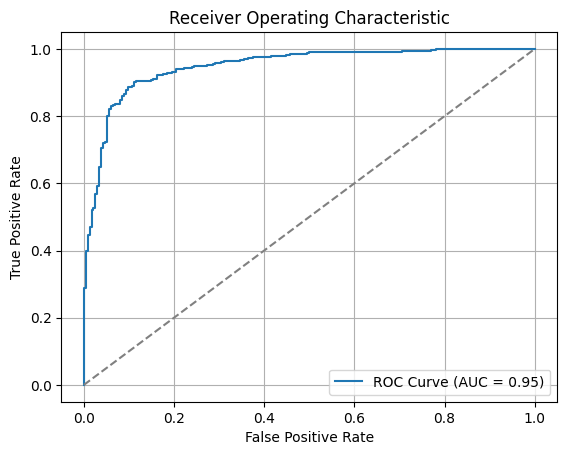

              precision    recall  f1-score   support

      Normal       0.92      0.65      0.77       234
   Pneumonia       0.82      0.97      0.89       393

    accuracy                           0.85       627
   macro avg       0.87      0.81      0.83       627
weighted avg       0.86      0.85      0.84       627

Test Accuracy: 0.8501
Model saved successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


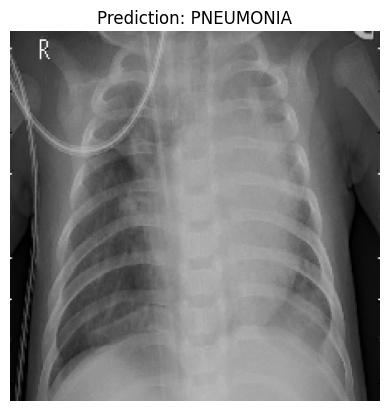

/home/jovyan/.local/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipykernel_4852/3058265032.py:173: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


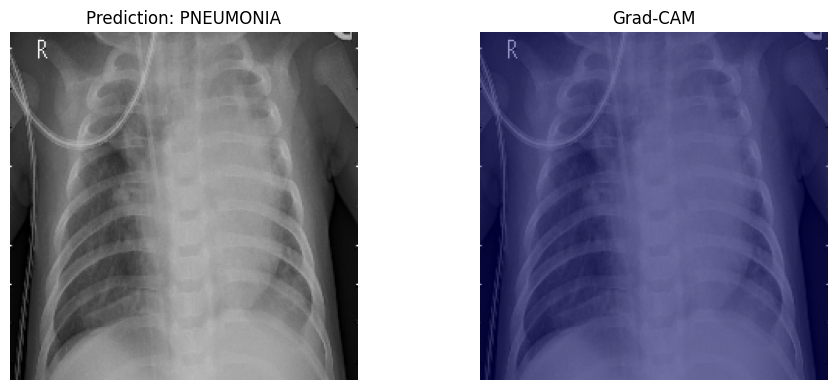

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import seaborn as sns
from sklearn.utils import class_weight
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# === 1. Load Full Dataset ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/chest_xray/chest_xray/train',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/chest_xray/chest_xray/train',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# === 2. Normalize & Prefetch ===
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# === 3. Build Model ===
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze for now

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === 4. Class Weights ===
y_train = []
for _, labels in train_ds:
    y_train.extend(labels.numpy())
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# === 5. Train Model ===
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# === 6. Evaluate on Test Set ===
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/chest_xray/chest_xray/test',
    image_size=(224, 224),
    batch_size=32
)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

y_true, y_pred, y_probs = [], [], []

for images, labels in test_ds:
    probs = model.predict(images)
    preds = (probs >= 0.5).astype(int).reshape(-1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_probs.extend(probs.flatten())

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === 8. ROC Curve ===
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

# === 9. Report & Accuracy ===
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# === 10. Save Model ===
os.makedirs('./saved_models', exist_ok=True)
model.save('./saved_models/chest_xray_densenet_model.keras')
print("Model saved successfully.")

# === 11. Predict a Single Image ===
img_path = './person100_bacteria_479.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

pred = model.predict(img_batch)[0][0]
predicted_class = 'PNEUMONIA' if pred >= 0.5 else 'NORMAL'

plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')
plt.show()

# === 12. Grad-CAM Visualization ===
model = tf.keras.models.load_model('./saved_models/chest_xray_densenet_model.keras')

base_model = model.layers[0]
last_conv_layer_name = 'conv5_block16_2_conv'
last_conv_layer = base_model.get_layer(last_conv_layer_name)

gap_layer = model.layers[1]
dense_1 = model.layers[2]
dropout = model.layers[3]
output_layer = model.layers[4]

grad_model = Model(
    inputs=base_model.input,
    outputs=[last_conv_layer.output, output_layer(dropout(dense_1(gap_layer(base_model.output))))]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_batch)
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)
heatmap = heatmap.numpy()

heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
original_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis('off')
plt.tight_layout()
plt.show()

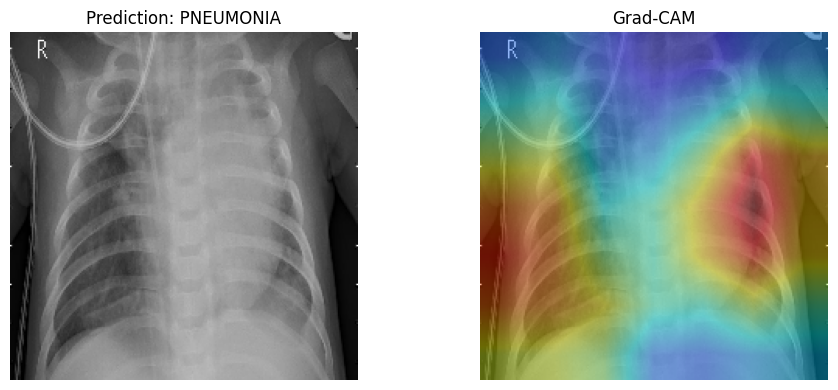

In [16]:
# === 12. Grad-CAM Visualization ===
model = tf.keras.models.load_model('./saved_models/chest_xray_densenet_model.keras')

base_model = model.layers[0]
last_conv_layer_name = 'conv5_block14_2_conv'
last_conv_layer = base_model.get_layer(last_conv_layer_name)

gap_layer = model.layers[1]
dense_1 = model.layers[2]
dropout = model.layers[3]
output_layer = model.layers[4]

grad_model = Model(
    inputs=base_model.input,
    outputs=[last_conv_layer.output, output_layer(dropout(dense_1(gap_layer(base_model.output))))]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_batch)
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)
heatmap = heatmap.numpy()

heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
original_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Count number of images in the training dataset
num_train_images = sum([x.shape[0] for x, _ in train_ds])
print(f"Total training images: {num_train_images}")

Total training images: 3653


In [18]:
# Count number of images in the test dataset
num_test_images = sum([x.shape[0] for x, _ in test_ds])
print(f"Total test images: {num_test_images}")

Total test images: 627


In [19]:
# Count number of images in the validation dataset
num_val_images = sum([x.shape[0] for x, _ in val_ds])
print(f"Total validation images: {num_val_images}")

Total validation images: 1565
